# Data Science - Laboratorio 3
## Modelos Long-Short Term Memory (LSTM)
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

### Librerias

In [1]:
# Manipulacion de Datos
import pandas as pd
import numpy as np

# Sistema
import os

# Utilidades
import random

# Visualizacion
import matplotlib.pyplot as plt

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# PyTorch CUDA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

### Carga de Datasets

In [2]:
# Leer los archivos de una carpeta y almacenarlos como dataframes
consumos = pd.read_csv('data/consumos_combustibles.csv', sep=';', encoding='utf-8')
importaciones = pd.read_csv('data/importaciones_combustibles.csv', sep=';', encoding='utf-8')
precios = pd.read_csv('data/precios_combustibles.csv', sep=';', encoding='utf-8')

data_frames = {
    'Consumos': consumos,
    'Importaciones': importaciones,
    'Precios': precios
}

# Mostrar los nombres de los archivos
print(f"Se cargaron un total de 3 archivos\n")
print('Archivos cargados:')
for key in data_frames.keys():
    print(f"\t- {key}")

Se cargaron un total de 3 archivos

Archivos cargados:
	- Consumos
	- Importaciones
	- Precios


## Preprocesamiento

### Seleccion de Variables

Solo se tomarán en cuenta los datos de importación, consumo y precios de los siguientes tipos de combustibles:
- `Gasolina Súper`
- `Gasolina Regular`
- `Diesel` -> combinacion de Diesel alto azufre y bajo azufre
- `Gas Propano`

In [3]:
# Seleccionar las columnas de interés para consumos e importaciones
cols = ['Fecha','Gasolina regular', 'Gasolina superior', 'Diesel alto azufre', 'Diesel bajo azufre', 'Gas licuado de petróleo']

# Filtrar columnas en 'consumo_combustibles'
consumos = consumos[cols].copy()

# Filtrar columnas en 'importacion_combustibles'
importaciones = importaciones[cols].copy()

# Filtrar columnas en 'precios_combustibles'
precios_cols = ['FECHA','Superior GTQ/GALON', 'Regular GTQ/GALON', 'Diesel GTQ/GALON', 'Glp Cilindro 25Lbs GTQ/LB']
precios = precios[precios_cols].copy()

### Verificacion y manejo de Nulos

En el laboratorio anterior se encontro que Ceras y tipo cambio eran las variables con nulos. Dado que ahora se seleccionaron las variables de interes antes, es probable que ya no existan nulos.

In [4]:
# Comprobar si hay valores nulos
print("Valores nulos en el dataset de consumo de combustibles:", consumos.isnull().sum().sum())
print("Valores nulos en el dataset de importación de combustibles:", importaciones.isnull().sum().sum())
print("Valores nulos en el dataset de precios de combustibles:", precios.isnull().sum().sum())

Valores nulos en el dataset de consumo de combustibles: 0
Valores nulos en el dataset de importación de combustibles: 0
Valores nulos en el dataset de precios de combustibles: 0


### Manejo de Fechas

Anterormente se encontro que los 3 datasets contienen una unica variable culitativa la cual es `Fecha`. Esta se encuentra como string por lo que se debe de transformar a datetime

In [5]:
# Diccionario de meses en español a inglés
month_mapping = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

# Función para reemplazar los nombres de los meses
def replace_months(date_str):
    for esp, eng in month_mapping.items():
        date_str = date_str.replace(esp, eng)
    return date_str

# Por fines practicos, se renombra la columna  'FECHA' a 'Fecha' en el dataset de precios de combustibles
precios.rename(columns={'FECHA': 'Fecha'}, inplace=True)

# Aplicar la función a las columnas de fecha de los dataframes
consumos['Fecha'] = consumos['Fecha'].apply(replace_months)
importaciones['Fecha'] = importaciones['Fecha'].apply(replace_months)
precios['Fecha'] = precios['Fecha'].apply(replace_months)

# Convertir las columnas de fecha a datetime
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], format='%b/%Y')
importaciones['Fecha'] = pd.to_datetime(importaciones['Fecha'], format='%b/%Y')
precios['Fecha'] = pd.to_datetime(precios['Fecha'], format='%d/%b/%Y')

# Establecer la columna 'Fecha' como índice en los tres dataframes
consumos.set_index('Fecha', inplace=True)
importaciones.set_index('Fecha', inplace=True)
precios.set_index('Fecha', inplace=True)

# Converir los indices a datetime
consumos.index = pd.to_datetime(consumos.index)
importaciones.index = pd.to_datetime(importaciones.index)
precios.index = pd.to_datetime(precios.index)

# Ordenar los índices
consumos.sort_index(inplace=True)
importaciones.sort_index(inplace=True)
precios.sort_index(inplace=True)

# Inferir la frecuencia de los índices
pd.infer_freq(consumos.index)
pd.infer_freq(importaciones.index)
pd.infer_freq(precios.index);

### Manejo de variables Diesel

Es necesario combinar ambas variables de diesel en una unica variable donde las fechas de antes del 2018 se tomaran para el diesel alto en azufre, posterior a 2018 se tomaran las de diesel alto en azufre.

In [6]:
def combine_diesel(df, high_sulfur_col, low_sulfur_col, combined_col):
    """
    Función que combina las columnas de Diesel de alto y bajo azufre en una sola columna.
    Toma los valores de Diesel de alto azufre hasta 2017 y los de Diesel de bajo azufre a partir de 2018.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        high_sulfur_col (str): El nombre de la columna de Diesel de alto azufre.
        low_sulfur_col (str): El nombre de la columna de Diesel de bajo azufre.
        combined_col (str): El nombre de la nueva columna combinada.
    
    Returns:
        data (pandas.DataFrame): El dataframe de entrada con la nueva columna combinada.
    """
    # Crear una copia del dataframe
    data = df.copy()

    # Crear una nueva columna con los valores de Diesel de alto azufre
    data.loc[data.index < '2018-01-01', combined_col] = data[high_sulfur_col]
    data.loc[data.index >= '2018-01-01', combined_col] = data[low_sulfur_col]

    # Eliminar las columnas originales
    data.drop(columns=[high_sulfur_col, low_sulfur_col], inplace=True)

    return data

In [7]:
# Combina las columnas de Diesel de alto y bajo azufre en una sola columna
consumos = combine_diesel(consumos, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')
importaciones = combine_diesel(importaciones, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')

### Renombrar Variables

Por fines practicos se renombraran las variables

In [8]:
precios.rename(columns={
    'Superior GTQ/GALON': 'Gasolina Superior',
    'Regular GTQ/GALON': 'Gasolina Regular',
    'Diesel GTQ/GALON': 'Diesel',
    'Glp Cilindro 25Lbs GTQ/LB': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'consumo_combustibles'
consumos.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'importacion_combustibles'
importaciones.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

## Modelos LSTM

### Configuracion de PyTorch con CUDA

In [9]:
# Configuración de la GPU
os.environ['CUDA_PATH'] = r"C:/Program Files/NVIDIA GPU Computing Toolkit//CUDA//v12.4"  # Ruta para CUDA 12.4

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    print(f"CUDA AVAILABLE")

    print(f"Using: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    # Configurar el generador de números aleatorios de CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU.

    # Configurar el dispositivo de PyTorch para usar la GPU
    device = torch.device("cuda")

    # Configurar PyTorch a determinista
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
else:
    # Si no hay GPU disponible, usar la CPU
    print("CUDA NOT AVAILABLE")
    print("Using CPU")
    device = torch.device("cpu")

CUDA AVAILABLE
Using: NVIDIA GeForce RTX 3070 Ti Laptop GPU


### Arquitectura y Pipeline de una LSTM con PyTorch CUDA

In [10]:
class LSTM_Model():
    """
    Clase para entrenar un modelo LSTM para predecir series temporales.

    Args:
        input_size (int): Número de features en la entrada.
        output_size (int): Número de features en la salida.
        hidden_layers (int): Número de capas ocultas.
        num_layers (int): Número de capas LSTM.
        lookback (int): Número de pasos de tiempo hacia atrás.
        n_epochs (int): Número de épocas.
        test_size (int): Tamaño del conjunto de prueba.
        device (torch.device): Dispositivo de PyTorch.
        dataframe (pandas.DataFrame): Dataframe de entrada.
        target_column (str): Columna objetivo.

    Attributes:
        input_size (int): Número de features en la entrada.
        output_size (int): Número de features en la salida.
        hidden_layers (int): Número de capas ocultas.
        num_layers (int): Número de capas LSTM.
        lookback (int): Número de pasos de tiempo hacia atrás.
        n_epochs (int): Número de épocas.
        test_size (int): Tamaño del conjunto de prueba.
        device (torch.device): Dispositivo de PyTorch.
        dataframe (pandas.DataFrame): Dataframe de entrada.
        target_column (str): Columna objetivo.
        model (torch.nn.Module): Modelo LSTM.
        loss_fn (torch.nn.Module): Función de pérdida.
        optimizer (torch.optim.Optimizer): Optimizador.
        loss_train (list): Lista para almacenar la pérdida de entrenamiento.
        loss_test (list): Lista para almacenar la pérdida de prueba.
        train_size (int): Tamaño del conjunto de entrenamiento.
    """
    def __init__(self, input_size, output_size, hidden_layers, num_layers, 
                 lookback, n_epochs, test_size, device, dataframe, target_column):
        
        # Inicializar los hiperparámetros
        self.input_size = input_size            # Número de features en la entrada
        self.output_size = output_size          # Número de features en la salida
        self.hidden_layers = hidden_layers      # Número de capas ocultas
        self.num_layers = num_layers            # Número de capas LSTM
        self.lookback = lookback                # Número de pasos de tiempo hacia atrás
        self.n_epochs = n_epochs                # Número de épocas
        self.test_size = test_size              # Tamaño del conjunto de prueba
        self.device = device                    # Dispositivo de PyTorch
        self.dataframe = dataframe              # Dataframe de entrada
        self.target_column = target_column      # Columna objetivo

        # Crear el modelo LSTM 
        self.model = self.build_lstm_model()

        # Definir la función de pérdida y el optimizador
        self.loss_fn = nn.MSELoss().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        # Listas para almacenar la pérdida
        self.loss_train = []
        self.loss_test = []

        # Entrenar el modelo
        self.train_model(dataframe, target_column)


    def build_lstm_model(self):
        """
        Función para construir el modelo LSTM.

        Returns:
            model (torch.nn.Module): El modelo LSTM.
        """
        class LSTM(nn.Module):
            def __init__(self, input_size, hidden_layers, output_size, num_layers):
                super(LSTM, self).__init__()
                
                # Definir la capa LSTM
                self.lstm = nn.LSTM(input_size = input_size, 
                                    hidden_size = hidden_layers, 
                                    num_layers = num_layers, 
                                    batch_first = True)
                
                # Definir la capa de salida
                self.linear = nn.Linear(hidden_layers, 
                                        output_size)
                
                # Agregar una capa de activación ReLU
                self.relu = nn.ReLU() 
                
                self.hidden_size = hidden_layers  # Numero de hidden states
                self.num_layers = num_layers    # Numero de capas
                

            def forward(self, x):
                # Inicializar los hidden states
                h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
                c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

                # Forward pass a la capa LSTM
                out, _ = self.lstm(x, (h0, c0))

                # Aplicar la capa de activación
                out = self.relu(out)
                
                # Solo se necesita el último hidden state
                out = self.linear(out)
                
                return out
            
        # Retornar el modelo LSTM con los hiperparámetros dados
        return LSTM(self.input_size, self.hidden_layers, self.output_size, self.num_layers).to(self.device)
    


    def create_dataset(self, dataset):
        """
        Función para crear el dataset de entrenamiento.

        Args:
            dataset (numpy.array): El dataset de entrada.

        Returns:
            X (torch.Tensor): El tensor de features.
            y (torch.Tensor): El tensor de target.
        """
        X, y = [], []
        for i in range(len(dataset) - self.lookback):
            feature = dataset[i : i + self.lookback]
            target = dataset[i + 1 : i + self.lookback + 1]
            X.append(feature)
            y.append(target)

        # Convertir listas a numpy arrays y luego a tensores
        X = np.array(X)
        y = np.array(y)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    

    def train_model(self, dataframe, variable):
        """
        Función para entrenar el modelo LSTM.

        Args:
            dataframe (pandas.DataFrame): El dataframe de entrada.

        Returns:
            None
        """
        # Copiar el dataframe
        df = dataframe.copy()
        # Seleccionar la variable objetivo
        timeseries = df[[variable]].values.astype(float)
        # Normalizar los datos
        scaler = StandardScaler()
        timeseries = scaler.fit_transform(timeseries)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        self.train_size = len(timeseries) - self.test_size
        train_data = timeseries[:self.train_size]
        test_data = timeseries[self.train_size:]

        # Crear el dataset de entrenamiento y prueba 
        X_train, y_train = self.create_dataset(train_data)
        X_test, y_test = self.create_dataset(test_data)

        # Mover los tensores al dispositivo
        X_train, y_train = X_train.to(self.device), y_train.to(self.device)
        X_test, y_test = X_test.to(self.device), y_test.to(self.device)

        # Crear un DataLoader para cargar los datos
        loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=16, shuffle=False)

        # Iteramos sobre cada epoca
        for epoch in range(self.n_epochs):
            # Colocamos el modelo en modo de entrenamiento
            self.model.train()

            # Cargamos los batches
            for X_batch, y_batch in loader:
                # Movemos los datos al dispositivo
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                # Obtenemos una primera prediccion
                y_pred = self.model(X_batch)
                # Calculamos la perdida
                loss = self.loss_fn(y_pred, y_batch)
                # Reseteamos la gradiente a cero
                #   sino la gradiente de previas iteraciones se acumulará con las nuevas
                self.optimizer.zero_grad()
                # Backpropagation
                loss.backward()
                # Aplicar las gradientes para actualizar los parametros del modelo
                self.optimizer.step()

            # Validación cada 100 epocas
            if epoch % 100 == 0 or epoch == self.n_epochs - 1:
                # Colocamos el modelo en modo de evaluación
                self.model.eval()

                # Deshabilitamos el calculo de gradientes
                with torch.no_grad():
                    # Prediccion de train
                    y_pred = self.model(X_train)
                    # Calculo del RMSE - Root Mean Square Error
                    train_rmse = np.sqrt(self.loss_fn(y_pred, y_train).cpu().numpy())
                    # Prediccion sobre validation
                    y_pred = self.model(X_test)
                    # Calculo del RMSE para validation
                    test_rmse = np.sqrt(self.loss_fn(y_pred, y_test).cpu().numpy())
                    # Almacenamos los resultados
                    self.loss_train.append(train_rmse)
                    self.loss_test.append(test_rmse)
                
                # Mostramos los resultados
                print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

            # Si hay GPU, sincronizamos el dispositivo
            if torch.cuda.is_available():
                torch.cuda.synchronize()

        # Graficamos los resultados finales
        self.plot_results(timeseries, X_train, X_test)


    def plot_results(self, timeseries, X_train, X_test):
        """
        Función para graficar los resultados.

        Args:
            timeseries (numpy.array): La serie temporal original.
            X_train (torch.Tensor): El tensor de features de entrenamiento.
            X_test (torch.Tensor): El tensor de features de prueba.

        Returns:
            None
        """
        
        epoch = np.arange(len(self.loss_train))
        plt.figure(figsize=(20, 7))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(epoch, self.loss_train, 'r', label='Training')
        plt.plot(epoch, self.loss_test, 'b', label='Test')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.title('Error del modelo por época')
        plt.legend()

        # Plot series
        with torch.no_grad():
            # Movemos las predicciones de train para graficar
            train_plot = np.ones_like(timeseries) * np.nan
            # Prediccion de train
            y_pred = self.model(X_train)
            # Extraemos los datos solo del ultimo paso
            y_pred = y_pred[:, -1, :]
            train_plot[self.lookback : self.train_size] = self.model(X_train)[:, -1, :].cpu().numpy()
            # Movemos las predicciones de test
            test_plot = np.ones_like(timeseries) * np.nan
            test_plot[self.train_size + self.lookback : len(timeseries)] = self.model(X_test)[:, -1, :].cpu().numpy()

            plt.subplot(1, 2, 2)
            plt.plot(timeseries, label="Original Series")
            plt.plot(train_plot, 'r', label="Train Predictions")
            plt.plot(test_plot, 'g', label="Test Predictions")
            plt.xlabel('Time Step')
            plt.ylabel('Value')
            plt.legend()
            plt.title("Predicciones del modelo")
        
        plt.suptitle(f"Rendimiento de la LSTM - {self.target_column}")
        plt.tight_layout()
        plt.show()

        # Imprimir el RMSE final
        print("Resultados finales del modelo:")
        print(f"RMSE de Entrenamiento: {self.loss_train[-1]:.4f}")
        print(f"RMSE de Pruebas: {self.loss_test[-1]:.4f}")

### Modelos

#### Consumos de Combustible

Epoch 0: train RMSE 0.8736, test RMSE 1.5157
Epoch 99: train RMSE 0.3293, test RMSE 0.4967


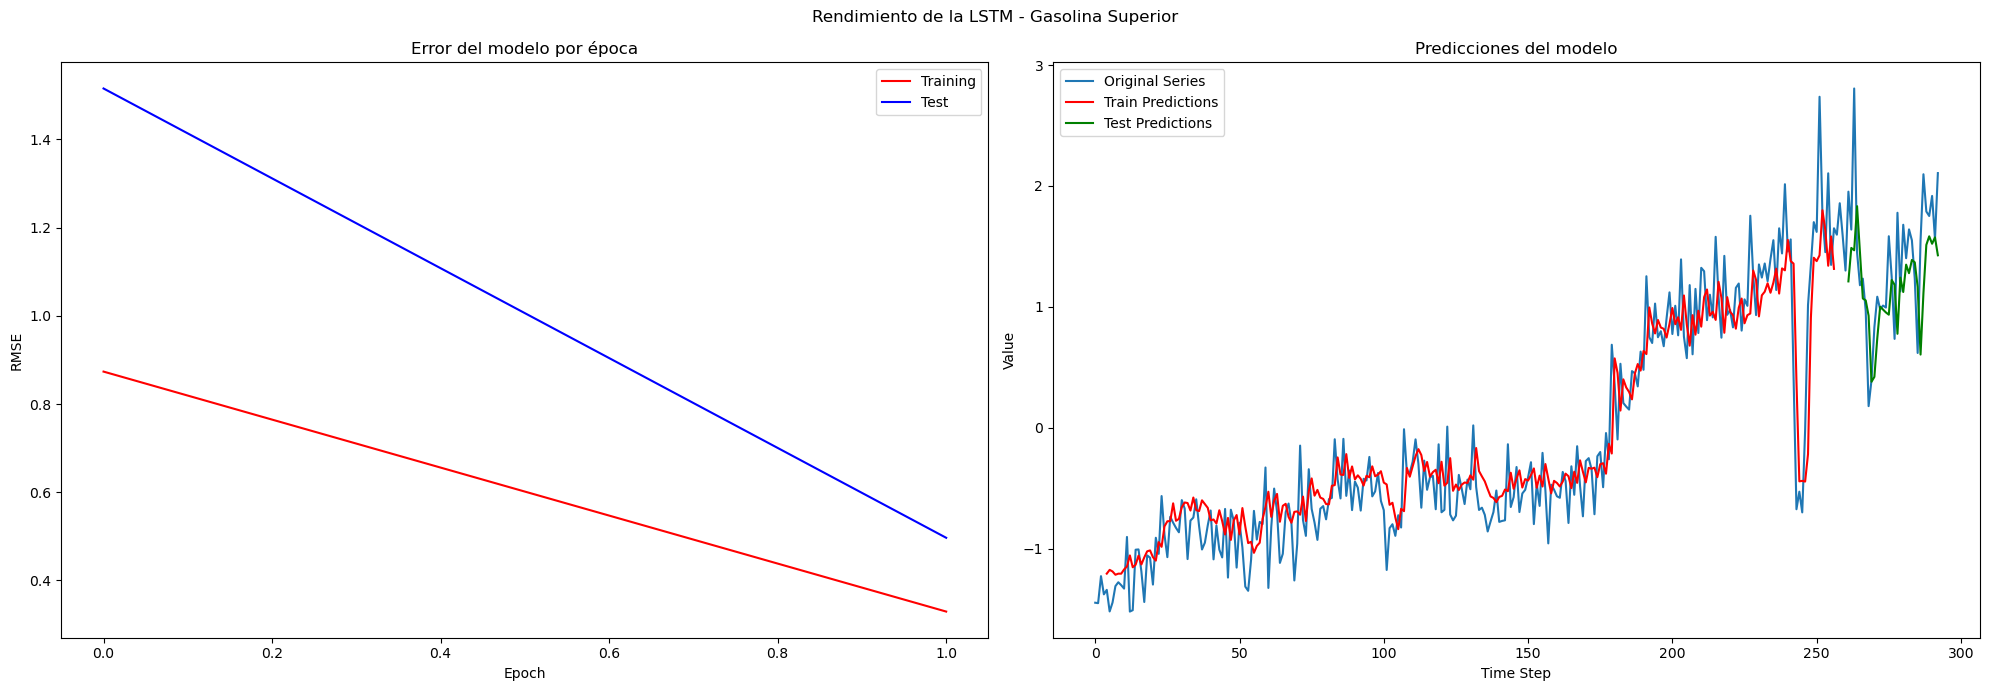

Resultados finales del modelo:
RMSE de Entrenamiento: 0.3293
RMSE de Pruebas: 0.4967


In [11]:
lstm_consumo_super1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Superior'
)

Epoch 0: train RMSE 0.8795, test RMSE 1.5082
Epoch 100: train RMSE 0.3213, test RMSE 0.4918
Epoch 200: train RMSE 0.3036, test RMSE 0.5150
Epoch 300: train RMSE 0.2974, test RMSE 0.5392
Epoch 400: train RMSE 0.2748, test RMSE 0.5358
Epoch 499: train RMSE 0.2722, test RMSE 0.5515


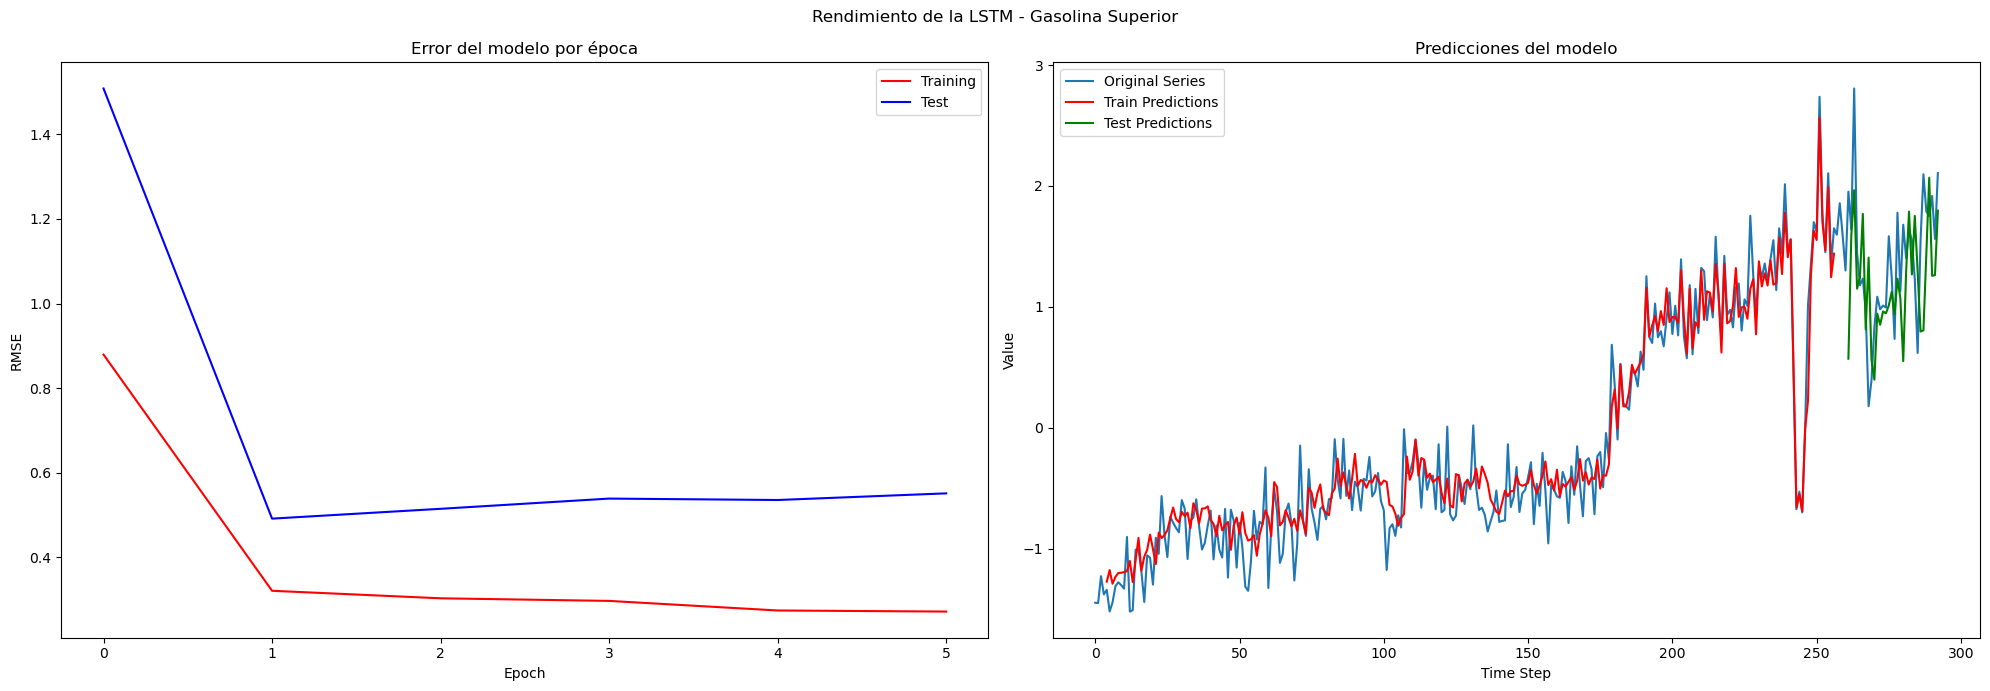

Resultados finales del modelo:
RMSE de Entrenamiento: 0.2722
RMSE de Pruebas: 0.5515


In [12]:
lstm_consumo_super2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=500,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Superior'
)

Epoch 0: train RMSE 0.7434, test RMSE 1.9856
Epoch 99: train RMSE 0.1473, test RMSE 0.3800


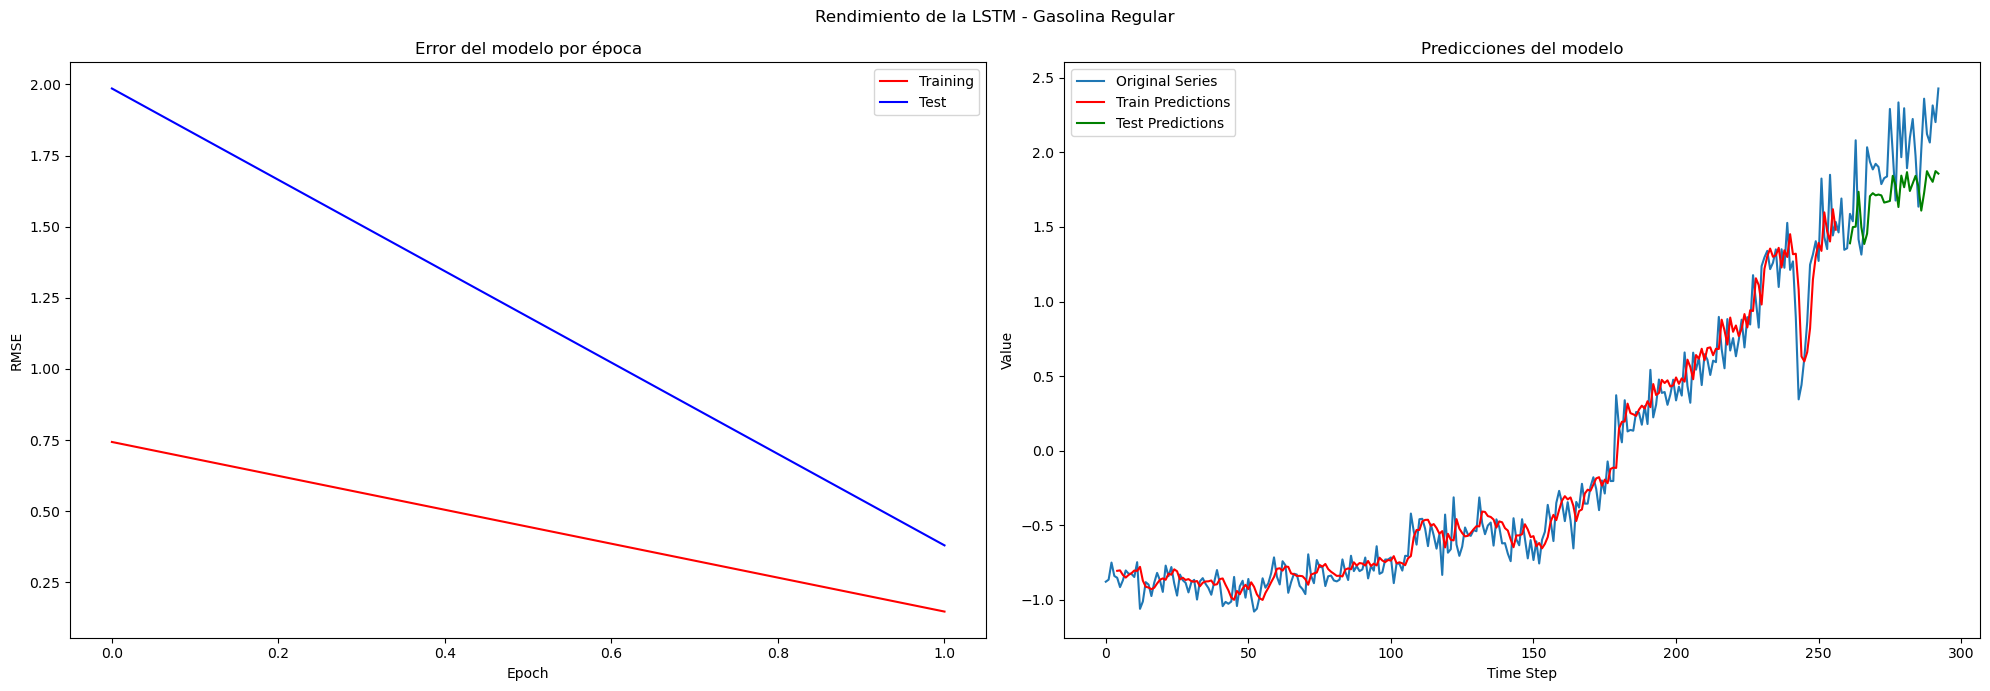

Resultados finales del modelo:
RMSE de Entrenamiento: 0.1473
RMSE de Pruebas: 0.3800


In [13]:
lstm_consumo_regular1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Regular'
)

Epoch 0: train RMSE 0.7256, test RMSE 2.0659
Epoch 100: train RMSE 0.1469, test RMSE 0.3699
Epoch 200: train RMSE 0.1460, test RMSE 0.3546
Epoch 300: train RMSE 0.1452, test RMSE 0.3591
Epoch 400: train RMSE 0.1421, test RMSE 0.3996
Epoch 499: train RMSE 0.1518, test RMSE 0.5369


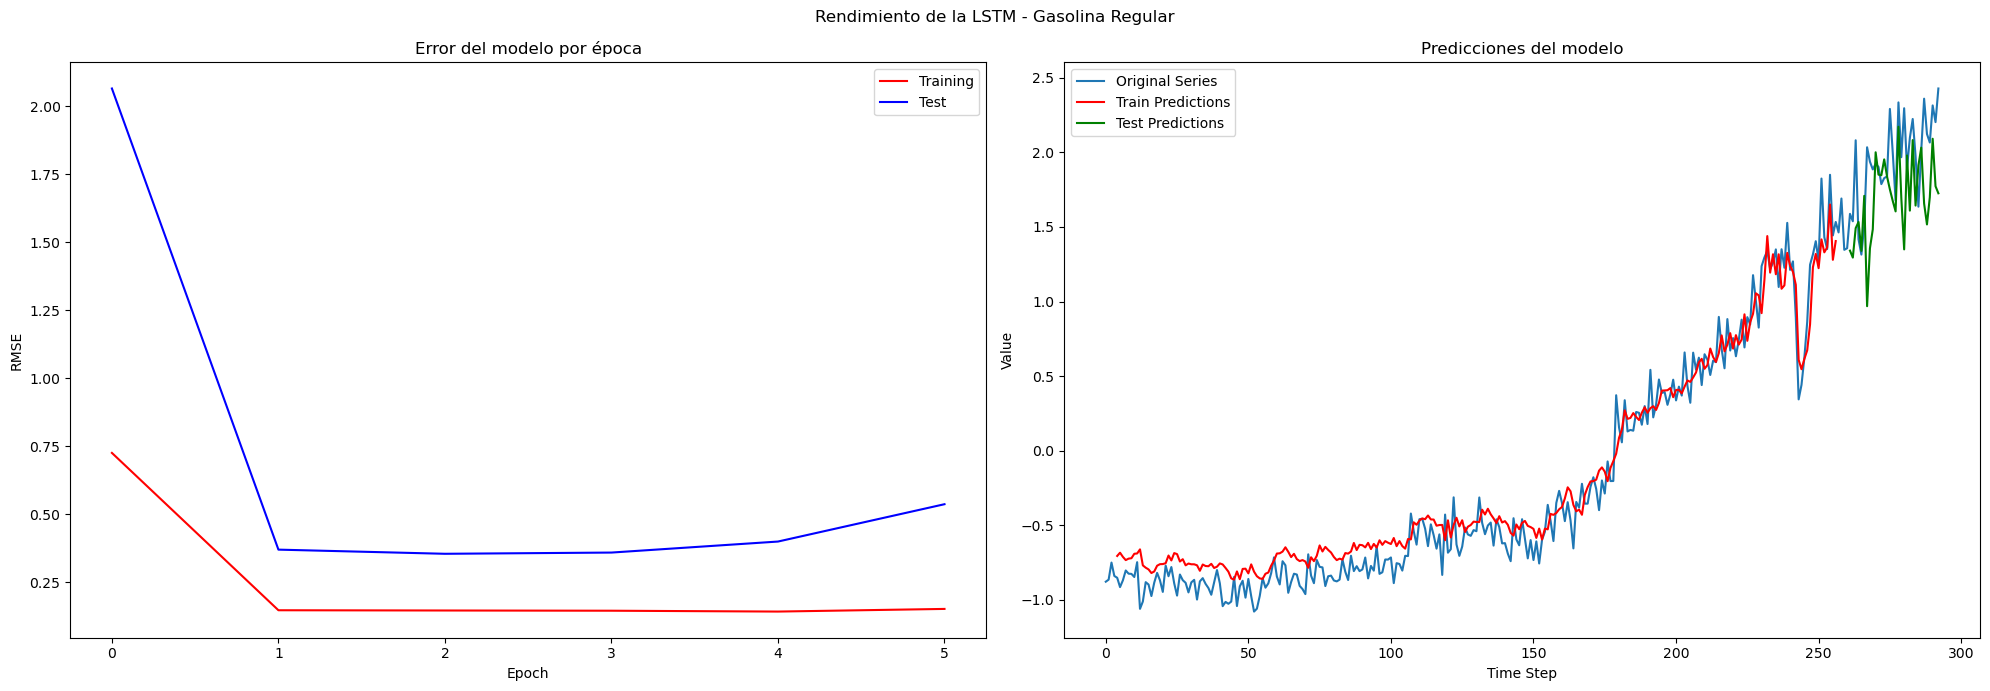

Resultados finales del modelo:
RMSE de Entrenamiento: 0.1518
RMSE de Pruebas: 0.5369


In [14]:
lstm_consumo_regular2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=500,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Regular'
)

Epoch 0: train RMSE 0.8078, test RMSE 1.7877
Epoch 99: train RMSE 0.3436, test RMSE 0.6026


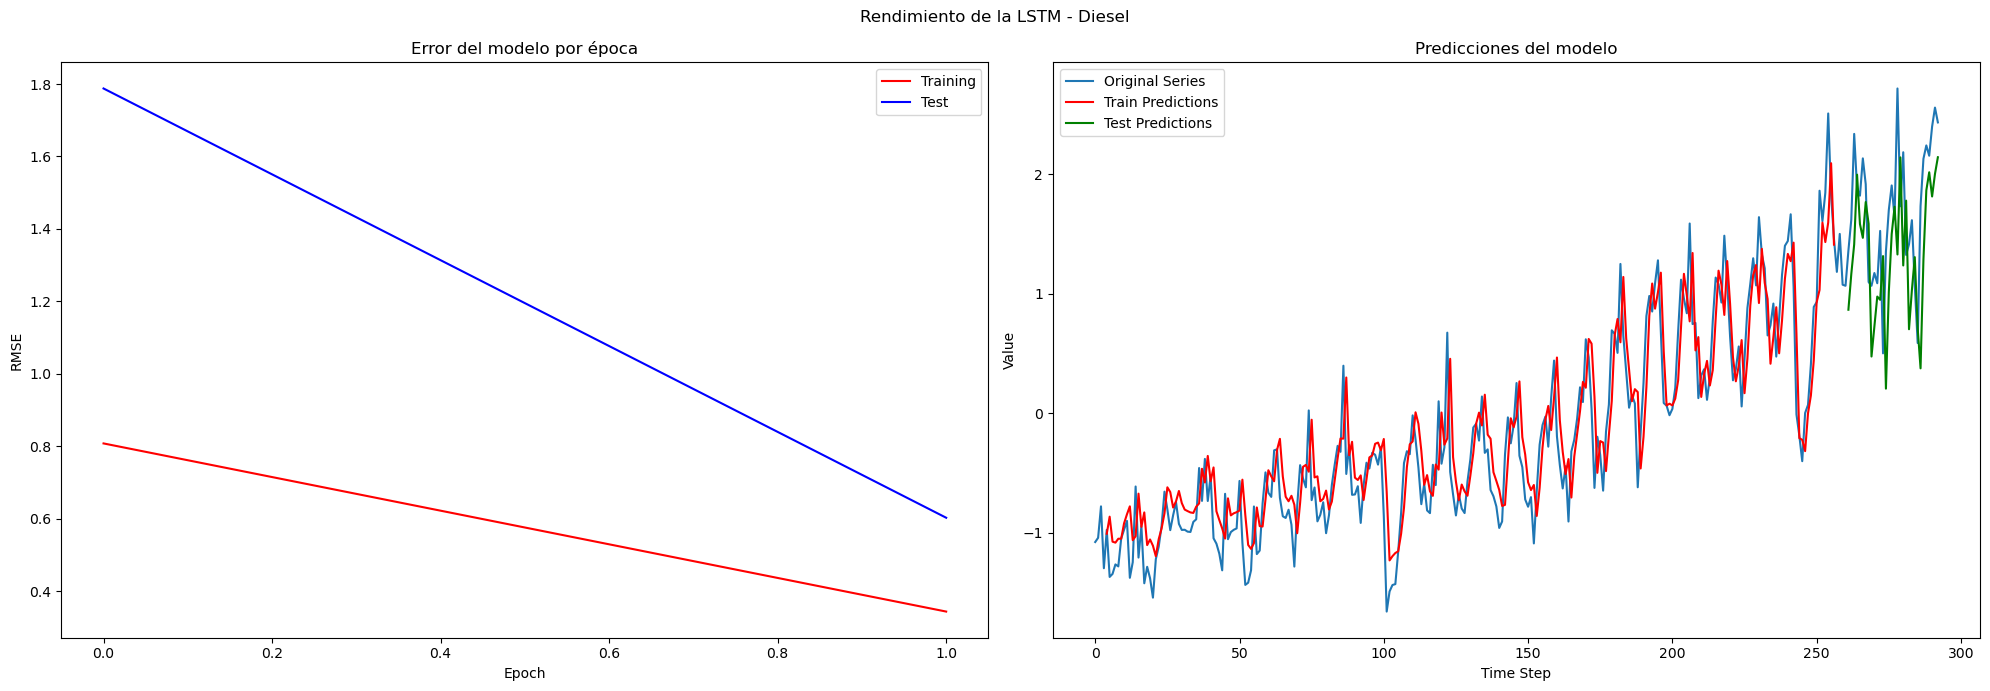

Resultados finales del modelo:
RMSE de Entrenamiento: 0.3436
RMSE de Pruebas: 0.6026


In [15]:
lstm_consumo_diesel1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Diesel'
)

Epoch 0: train RMSE 0.8300, test RMSE 1.6704
Epoch 100: train RMSE 0.3414, test RMSE 0.6148
Epoch 200: train RMSE 0.3291, test RMSE 0.6386
Epoch 300: train RMSE 0.3226, test RMSE 0.7118
Epoch 400: train RMSE 0.2927, test RMSE 0.6644
Epoch 499: train RMSE 0.2843, test RMSE 0.6510


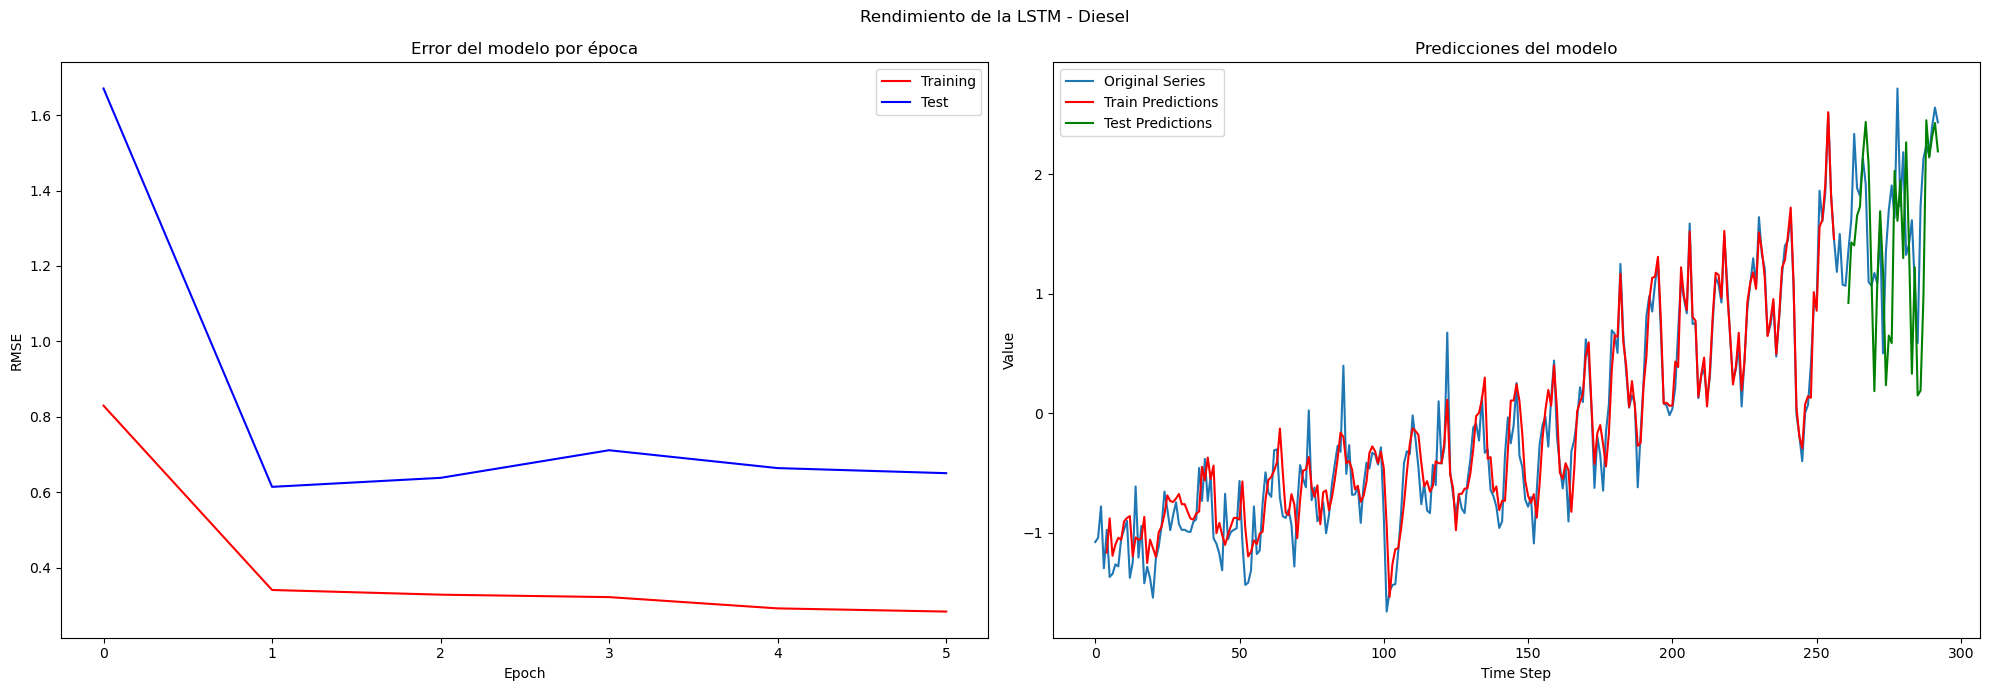

Resultados finales del modelo:
RMSE de Entrenamiento: 0.2843
RMSE de Pruebas: 0.6510


In [16]:
lstm_consumo_diesel2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=500,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Diesel'
)

Epoch 0: train RMSE 0.7690, test RMSE 1.9275
Epoch 99: train RMSE 0.1662, test RMSE 0.4427


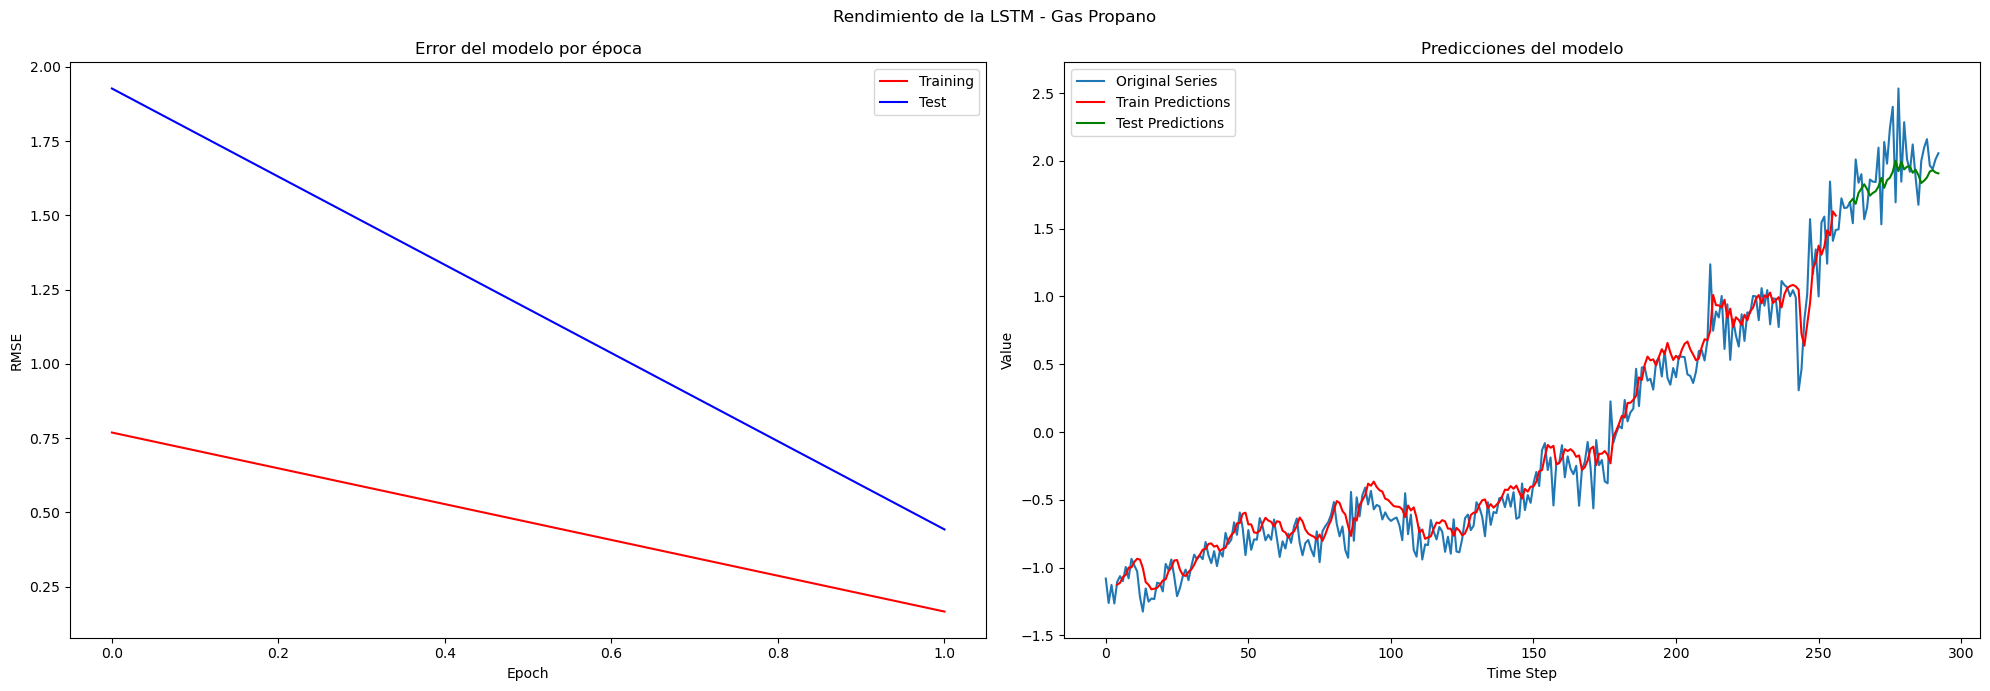

Resultados finales del modelo:
RMSE de Entrenamiento: 0.1662
RMSE de Pruebas: 0.4427


In [17]:
lstm_consumo_propano1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gas Propano'
)

Epoch 0: train RMSE 0.7714, test RMSE 1.9048
Epoch 100: train RMSE 0.1618, test RMSE 0.4654
Epoch 200: train RMSE 0.1702, test RMSE 0.4455
Epoch 300: train RMSE 0.1711, test RMSE 0.4527
Epoch 400: train RMSE 0.1580, test RMSE 0.5037
Epoch 499: train RMSE 0.1460, test RMSE 0.5005


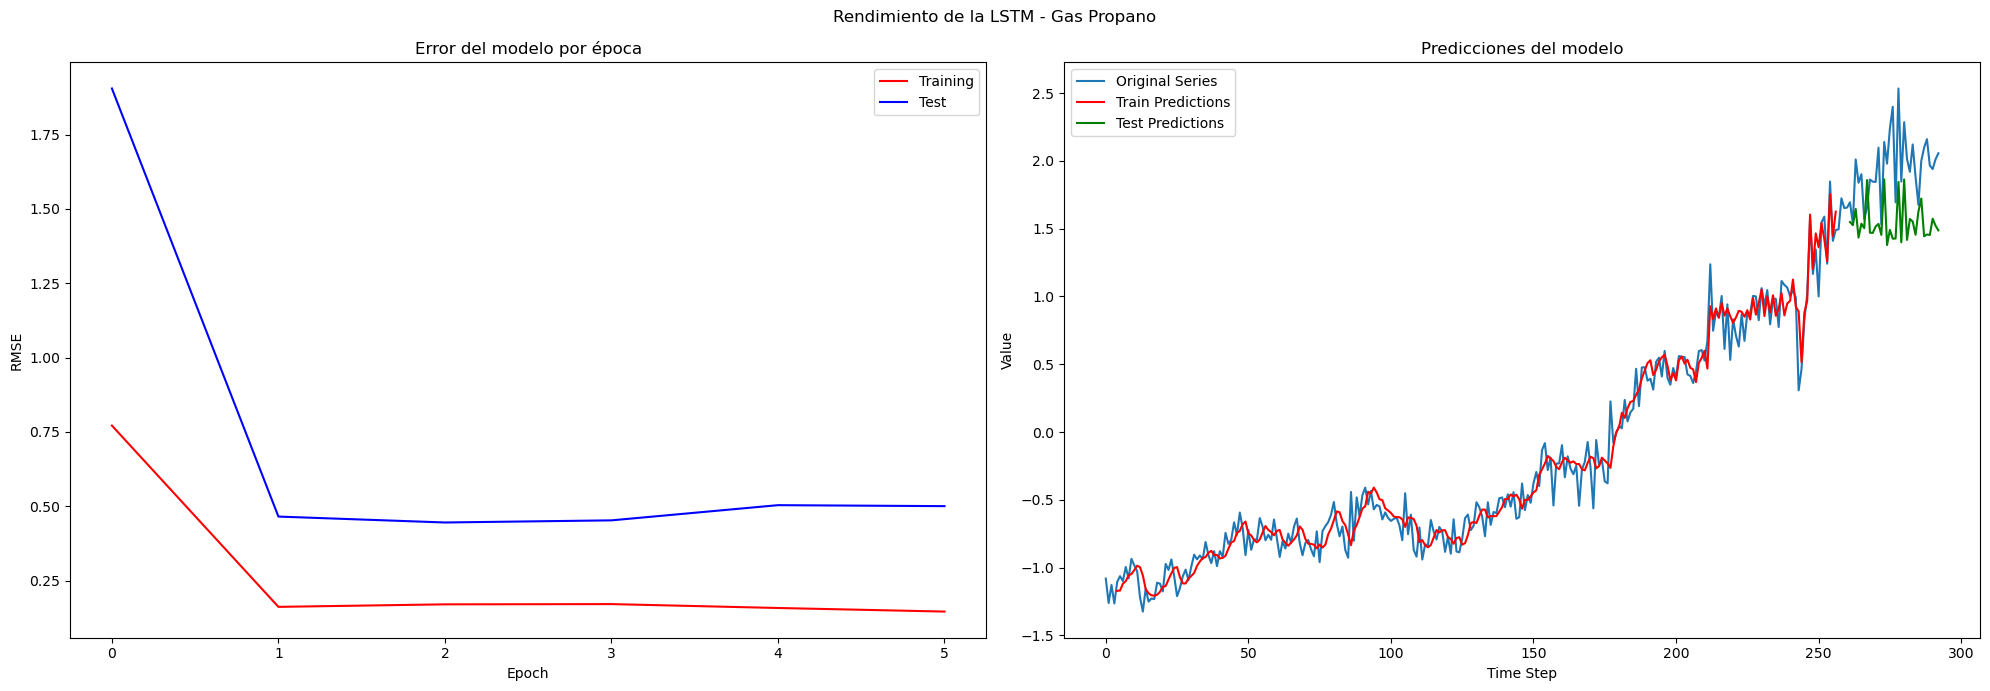

Resultados finales del modelo:
RMSE de Entrenamiento: 0.1460
RMSE de Pruebas: 0.5005


In [18]:
lstm_consumo_propano2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=500,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gas Propano'
)